In [1]:
import yfinance as yahooFinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy

Importing Data Into Pandas Dataframe:

In [12]:
tickers = ["JPM", "PFE", "NFLX", "FNB", "BP"]
hist_df = pd.DataFrame(columns=tickers)
for ticker in tickers:
    info = yahooFinance.Ticker(ticker)
    hist_df[ticker] = info.history(period="1y")["Close"]
hist_df.head()

,JPM,PFE,NFLX,FNB,BP
Date,,,,,
2023-03-29 00:00:00-04:00,125.554054,38.280441,332.029999,11.213083,35.944443
2023-03-30 00:00:00-04:00,125.174889,38.404079,338.429993,11.049740,36.221008
2023-03-31 00:00:00-04:00,126.691559,38.803532,345.480011,11.145824,36.182865
2023-04-03 00:00:00-04:00,126.545731,39.326614,348.279999,10.963263,37.899506
2023-04-04 00:00:00-04:00,124.854050,38.898640,346.750000,10.847961,37.508492


Adding on the "Risk-Free-Rate" (approximated as 5%) for comparison and normalizing each contract to start with a value of 1.0:

In [17]:
normalized_hist_df = hist_df/hist_df.loc[hist_df.index[0]]

# formula for compound interest: P(t) = P0*e^(r*t)
# since t is in years, use T/252 for the 252 business days in a year
# use interest rate (r) of 5%
r = 0.05
interest_rate_val = [1*np.exp(r*T/252) for T in range(len(normalized_hist_df))]
normalized_hist_df["InterestRate"] = interest_rate_val
normalized_hist_df.head()

,JPM,PFE,NFLX,FNB,BP,InterestRate
Date,,,,,,
2023-03-29 00:00:00-04:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2023-03-30 00:00:00-04:00,0.996980,1.003230,1.019275,0.985433,1.007694,1.000198
2023-03-31 00:00:00-04:00,1.009060,1.013665,1.040508,0.994002,1.006633,1.000397
2023-04-03 00:00:00-04:00,1.007898,1.027329,1.048941,0.977721,1.054391,1.000595
2023-04-04 00:00:00-04:00,0.994425,1.016149,1.044333,0.967438,1.043513,1.000794


Creating a plot to show the relationship between returns of the different financial contracts over time:

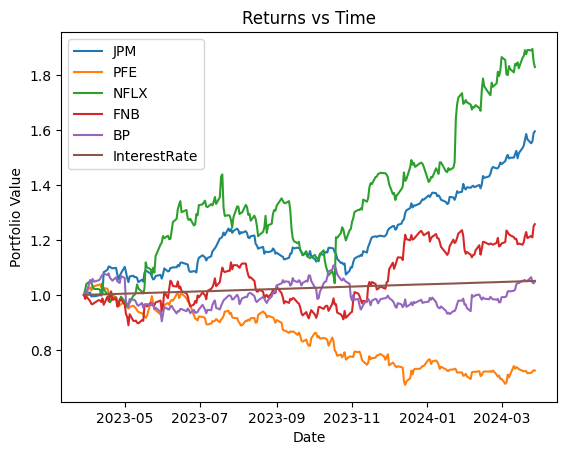

In [73]:
plt.plot(normalized_hist_df)
plt.title("Returns vs Time")
plt.ylabel("Portfolio Value")
plt.xlabel("Date")
plt.legend(normalized_hist_df.columns)

Creating various portfolios comprised of different compositions of fetched stocks + bonds at the "Risk-Free-Rate":

['JPM', 'PFE', 'NFLX', 'FNB', 'BP']


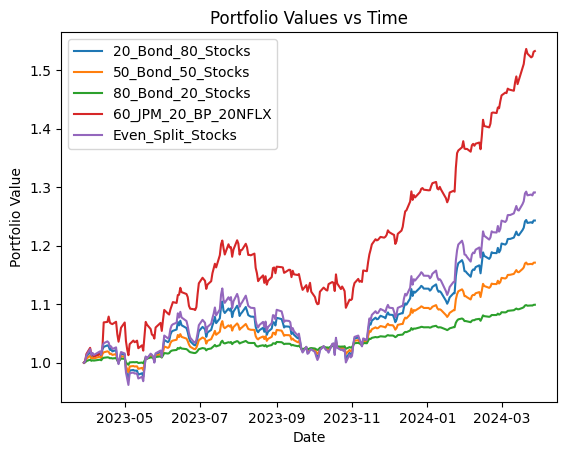

In [72]:
strategy_df = pd.DataFrame()
print(tickers)
def partitionPortfolioStocksAndBonds(hist_df, stocks, percent_bond):
    strategy = sum(normalized_hist_df[ticker] * ((1 - percent_bond) / len(stocks)) for ticker in stocks)
    strategy += hist_df["InterestRate"] * percent_bond
    return strategy
strategy_df["20_Bond_80_Stocks"] = partitionPortfolioStocksAndBonds(normalized_hist_df, tickers, 0.2)
strategy_df["50_Bond_50_Stocks"] = partitionPortfolioStocksAndBonds(normalized_hist_df, tickers, 0.5)
strategy_df["80_Bond_20_Stocks"] = partitionPortfolioStocksAndBonds(normalized_hist_df, tickers, 0.8)
strategy_df["60_JPM_20_BP_20NFLX"] = (0.2 * normalized_hist_df["BP"] + 
                                      0.2 * normalized_hist_df["NFLX"] + 
                                      0.6 * normalized_hist_df["JPM"])
strategy_df["Even_Split_Stocks"] = sum((1 / (len(tickers)) * normalized_hist_df[ticker] for ticker in tickers))
plt.plot(strategy_df)

plt.title("Portfolio Values vs Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend(strategy_df.columns, loc="upper left")

In [45]:
strategy_df.head()


,20_Bond_80_Stocks,50_Bond_50_Stocks,80_Bond_20_Stocks,60_JPM_20_BP_20NFLX,Even_Split_Stocks
Date,,,,,
2023-03-29 00:00:00-04:00,1.000000,1.000000,1.000000,1.000000,1.000000
2023-03-30 00:00:00-04:00,1.002058,1.001360,1.000663,1.003582,1.002522
2023-03-31 00:00:00-04:00,1.010298,1.006585,1.002872,1.014864,1.012774
2023-04-03 00:00:00-04:00,1.018724,1.011926,1.005128,1.025406,1.023256
2023-04-04 00:00:00-04:00,1.010696,1.006983,1.003269,1.014224,1.013172


Calculating the Sharpe Ratio for each of the different portfolios and visualizing the results:

In [51]:
# Define the strategy name
strat_name = "20_Bond_80_Stocks"

# Calculate returns minus risk-free rate
returns_minus_risk_free_rate = strategy_df[strat_name] - normalized_hist_df["InterestRate"]

# Calculate average adjusted returns and standard deviation of adjusted returns
avg_adj_returns = np.mean(returns_minus_risk_free_rate)
std_adj_returns = np.std(returns_minus_risk_free_rate)

# Calculate Sharpe ratio
sharpe_ratio = avg_adj_returns / std_adj_returns

print("Sharpe Ratio:", sharpe_ratio)

Sharpe Ratio: 0.9642666537855363


In [63]:
rows = []
for strat_name in strategy_df.columns:
    avg_strat_returns = np.mean(strategy_df[strat_name])
    avg_risk_free_returns = np.mean(normalized_hist_df["InterestRate"])
    std_adj_returns = np.std(returns_minus_risk_free_rate)
    sharpe_ratio = (avg_strat_returns - avg_risk_free_returns ) / std_adj_returns
    rows.append([strat_name, sharpe_ratio])

sharpe_ratio_df = pd.DataFrame(rows, columns=["Strategy", "Sharpe_Ratio"]).sort_values(by="Sharpe_Ratio")
sharpe_ratio_df

,Strategy,Sharpe_Ratio
2,80_Bond_20_Stocks,0.241067
1,50_Bond_50_Stocks,0.602667
0,20_Bond_80_Stocks,0.964267
4,Even_Split_Stocks,1.205333
3,60_JPM_20_BP_20NFLX,3.171055


Text(0.5, 0, 'Portfolio Composition')

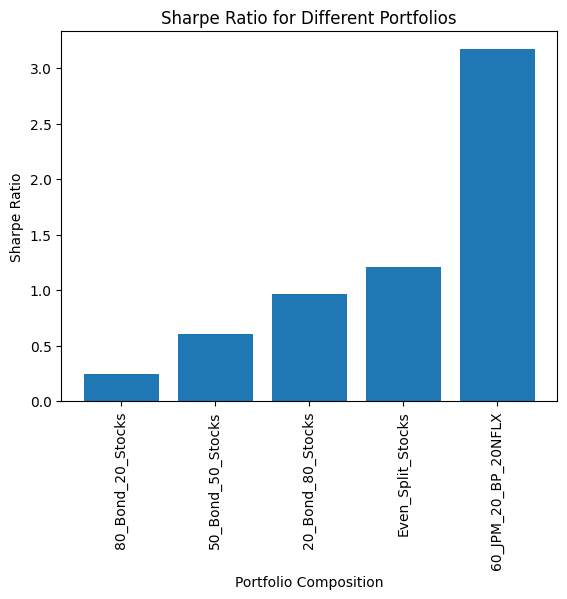

In [70]:
plt.bar(sharpe_ratio_df["Strategy"], sharpe_ratio_df["Sharpe_Ratio"])
plt.xticks(rotation=90)
plt.title("Sharpe Ratio for Different Portfolios")
plt.ylabel("Sharpe Ratio")
plt.xlabel("Portfolio Composition")